In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip3 install face_recognition

#To check the video if correpted, here i am checking video, if it is correpted i am deleting that
import glob
import torch
import torchvision
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset



def validate_video(video_path, transform, num_frames=20):
    frames = []
    vid_cap = cv2.VideoCapture(video_path)
    total_frames = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    for i in range(total_frames):
        success, frame = vid_cap.read()
        if not success:
            break
        if i in frame_indices:
            frames.append(transform(frame))
    vid_cap.release()
    return torch.stack(frames)


def frame_extract(video_path):
    vid_cap = cv2.VideoCapture(video_path)
    while True:
        success, frame = vid_cap.read()
        if not success:
            break
        yield frame
    vid_cap.release()


if __name__ == "__main__":
    im_size = 112
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])

    fake_video_paths = glob.glob('/content/drive/MyDrive/data here/DFDC_FAKE_Face_only_data/*.mp4')
    real_video_paths = glob.glob('/content/drive/MyDrive/data here/DFDC_REAL_Face_only_data/*.mp4')
    video_paths = fake_video_paths + real_video_paths

    print("Total number of videos:", len(video_paths))
    corrupted_videos = []

    for index, video_path in enumerate(video_paths, start=1):
        try:
            validate_video(video_path, train_transforms)
        except:
            print("Number of videos processed:", index, "Remaining:", len(video_paths) - index)
            print("Corrupted video:", video_path)
            corrupted_videos.append(video_path)

    print("Number of corrupted videos:", len(corrupted_videos))

Total number of videos: 3293
Number of corrupted videos: 0


In [ ]:
#loading video to memory
import json
import glob
import numpy as np
import cv2
import copy
import random

video_files =  glob.glob('/content/drive/MyDrive/data here/DFDC_FAKE_Face_only_data/*.mp4')
video_files += glob.glob('/content/drive/MyDrive/data here/DFDC_REAL_Face_only_data/*.mp4')

random.shuffle(video_files)
random.shuffle(video_files)
random.shuffle(video_files)
random.shuffle(video_files)

valid_video_files = []
frame_count = []

for video_file in video_files:
    cap = cv2.VideoCapture(video_file)
    frame_count_prop = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count_prop >= 100:
        frame_count.append(frame_count_prop)
        valid_video_files.append(video_file)

video_files = valid_video_files

print("frame counts are " , frame_count)
print("Total numbers of videos: " , len(frame_count))
print('average frame per video:',np.mean(frame_count))

frame counts are  [148, 148, 148, 148, 148, 148, 148, 145, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 144, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 1

In [ ]:
 #loading labels REAL or Fake from given CSV file
import torch
import torchvision
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset


class video_dataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=60, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_names)

    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = True
        while success:
            success, image = vidObj.read()
            if success:
                yield image

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        sequence_length = self.sequence_length
        frame_indices = self.get_frame_indices(sequence_length)
        temp_video = video_path.split('/')[-1]
        label = self.get_label(temp_video)

        for i, frame in enumerate(self.frame_extract(video_path)):
            if i in frame_indices:
                frames.append(self.transform(frame))
                if len(frames) == sequence_length:
                    break

        frames = torch.stack(frames)[:sequence_length]
        return frames, label

    def get_frame_indices(self, sequence_length):
        total_frames = 100
        step = total_frames / sequence_length
        return [int(step * i) for i in range(sequence_length)]

    def get_label(self, temp_video):
        label = self.labels.iloc[(self.labels.loc[self.labels["file"] == temp_video].index.values[0]), 1]
        return 0 if label == 'FAKE' else 1


#ploting image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
#count numbers for real and fake videos

import pandas as pd

def number_of_real_and_fake_videos(data_list):
    header_list = ["file", "label"]
    df = pd.read_csv('/content/drive/MyDrive/data here/datadfdc.csv', names=header_list)
    fake_count = 0
    real_count = 0

    for path in data_list:
        temp_video = path.split('/')[-1]
        label = df.loc[df["file"] == temp_video, "label"].iloc[0]
        if label == 'FAKE':
            fake_count += 1
        elif label == 'REAL':
            real_count += 1

    return real_count, fake_count

train :  2617
test :  655


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


TRAIN:  Real: 1383  Fake: 1234
TEST:  Real: 338  Fake: 317


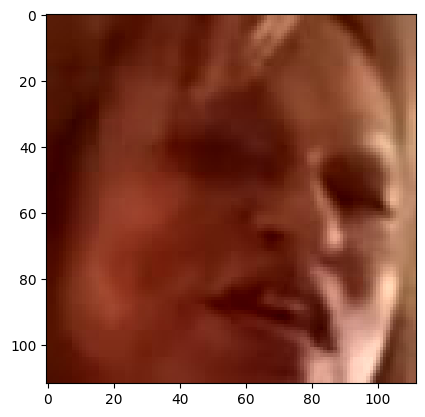

In [ ]:
# load the labels and video in data loader

import random
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader

header_list = ["file","label"]
labels = pd.read_csv('/content/drive/MyDrive/data here/datadfdc.csv', names=header_list)

train_videos = video_files[:int(0.8 * len(video_files))]
valid_videos = video_files[int(0.8 * len(video_files)):]
print("train : ", len(train_videos))
print("test : ", len(valid_videos))

train_real_fake = number_of_real_and_fake_videos(train_videos)
test_real_fake = number_of_real_and_fake_videos(valid_videos)

print("TRAIN: ", "Real:", train_real_fake[0], " Fake:", train_real_fake[1])
print("TEST: ", "Real:", test_real_fake[0], " Fake:", test_real_fake[1])

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_data = video_dataset(train_videos, labels, sequence_length=10, transform=train_transforms)
val_data = video_dataset(valid_videos, labels, sequence_length=10, transform=train_transforms)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(val_data, batch_size=4, shuffle=True, num_workers=4)

image, label = train_data[0]
im_plot(image[0, :, :, :])


In [ ]:
#Model feature extraction and LSTM
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(2048, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        features = self.features(x)
        x = self.avgpool(features)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        x_lstm_mean = torch.mean(x_lstm, dim=1)
        return features, self.dropout(self.fc(x_lstm_mean))


In [ ]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# import torch.nn.functional as F
# from torch import nn

# class TCNBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, padding=1):
#         super(TCNBlock, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
#         self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
#         self.relu = nn.ReLU()
#         self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

#     def forward(self, x):
#         out = self.relu(self.conv1(x))
#         out = self.conv2(out)
#         residual = x if self.downsample is None else self.downsample(x)
#         return self.relu(out + residual)


In [ ]:
# from torchvision import models

# class TCNModel(nn.Module):
#     def __init__(self, num_classes, latent_dim=2048, num_tcn_blocks=3, hidden_dim=2048):
#         super(TCNModel, self).__init__()
#         model = models.resnext50_32x4d(pretrained=True)
#         self.feature_extractor = nn.Sequential(*list(model.children())[:-2])
#         self.tcn = nn.Sequential(*[TCNBlock(hidden_dim, hidden_dim) for _ in range(num_tcn_blocks)])
#         self.relu = nn.LeakyReLU()
#         self.dp = nn.Dropout(0.4)
#         self.linear = nn.Linear(hidden_dim, num_classes)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)

#     def forward(self, x):
#         batch_size, seq_length, c, h, w = x.shape
#         x = x.view(batch_size * seq_length, c, h, w)
#         fmap = self.feature_extractor(x)  # Extract features from each frame
#         x = self.avgpool(fmap)
#         x = x.view(batch_size, seq_length, -1).permute(0, 2, 1)  # Permute to (batch_size, channels, seq_length)
#         x = self.tcn(x)  # Apply TCN
#         x = torch.mean(x, dim=2)  # Global average pooling over sequence dimension
#         x = self.dp(self.linear(x))
#         return fmap, x


In [ ]:
# model = TCNModel(2).cuda()
# a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

In [ ]:
# from torch import nn
# from torchvision import models
# class CNNModel(nn.Module):
#     def __init__(self, num_classes):
#         super(CNNModel, self).__init__()
#         model = models.resnext50_32x4d(pretrained=True)
#         self.model = nn.Sequential(*list(model.children())[:-2])
#         self.avgpool = nn.AdaptiveAvgPool2d(1)
#         self.dp = nn.Dropout(0.4)
#         self.linear1 = nn.Linear(2048, num_classes)

#     def forward(self, x):
#         batch_size, seq_length, c, h, w = x.shape
#         x = x.view(batch_size * seq_length, c, h, w)
#         fmap = self.model(x)
#         x = self.avgpool(fmap)
#         x = x.view(batch_size, seq_length, 2048)
#         # No LSTM layer
#         return fmap, self.dp(self.linear1(torch.mean(x, dim=1)))

In [ ]:
# import torch
# from torch import nn
# from torchvision import models

# class ModelWithInceptionV3(nn.Module):
#     def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
#         super(ModelWithInceptionV3, self).__init__()
#         # Initialize InceptionV3 with the default aux_logits=True
#         self.inception = models.inception_v3(pretrained=True)
#         # Adjust the Inception model by removing the final fully connected layer and auxiliary classifier
#         self.inception.fc = nn.Identity()
#         self.inception.aux_logits = False

#         self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
#         self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

#     def forward(self, x):
#         batch_size, seq_length, c, h, w = x.shape
#         x = x.view(batch_size * seq_length, c, h, w)

#         # Process input through InceptionV3 to extract features
#         # Assuming self.inception is your modified InceptionV3 model
#         features = self.inception(x)  # This outputs features of shape [batch_size * seq_length, 2048, 1, 1]

#         # Flatten features for each frame
#         features = features.view(batch_size * seq_length, -1)  # Now shape [batch_size * seq_length, 2048]

#         # Reshape to [batch_size, seq_length, 2048] for LSTM processing
#         features = features.view(batch_size, seq_length, -1)

#         # Process sequence of features with LSTM
#         lstm_out, _ = self.lstm(features)
#         processed_output = self.fc(lstm_out[:, -1, :])

#         return features, processed_output


In [ ]:
# model = ModelWithInceptionV3(2).cuda()
# a, b = model(torch.from_numpy(np.empty((1, 20, 3, 299, 299))).type(torch.cuda.FloatTensor))

In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _, outputs = model(inputs)
        loss = criterion(outputs, targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %.4f, Acc: %.2f%%]"
            % (
                epoch,
                num_epochs,
                i + 1,
                len(data_loader),
                losses.avg,
                accuracies.avg
            )
        )
    torch.save(model.state_dict(), '/content/checkpoint.pt')
    return losses.avg, accuracies.avg

def test(epoch, model, data_loader, criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    true = []
    pred = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _, outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
            _, p = torch.max(outputs, 1)
            true += targets.type(torch.cuda.LongTensor).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                "\r[Batch %d/%d] [Loss: %.4f, Acc: %.2f%%]"
                % (
                    i + 1,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg
                )
            )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true, pred, losses.avg, accuracies.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100 * n_correct_elems / batch_size


In [ ]:
def plot_loss(train_loss_avg, test_loss_avg, num_epochs):
    loss_train = train_loss_avg
    loss_val = test_loss_avg
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(train_accuracy, test_accuracy, num_epochs):
    loss_train = train_accuracy
    loss_val = test_accuracy
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')

    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()

    calculated_acc = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
    print("Calculated Accuracy", calculated_acc * 100)


[Epoch 1/20] [Batch 655/655] [Loss: 0.3937, Acc: 86.09%]Testing
[Batch 164/164] [Loss: 0.2966, Acc: 87.02%]
Accuracy 87.02290076335878
[Epoch 2/20] [Batch 655/655] [Loss: 0.3784, Acc: 88.15%]Testing
[Batch 164/164] [Loss: 0.2544, Acc: 89.62%]
Accuracy 89.61832061068702
[Epoch 3/20] [Batch 655/655] [Loss: 0.3775, Acc: 87.81%]Testing
[Batch 164/164] [Loss: 0.2558, Acc: 88.70%]
Accuracy 88.70229007633588
[Epoch 4/20] [Batch 655/655] [Loss: 0.3245, Acc: 90.26%]Testing
[Batch 164/164] [Loss: 0.2663, Acc: 89.92%]
Accuracy 89.92366412213741
[Epoch 5/20] [Batch 655/655] [Loss: 0.2925, Acc: 91.90%]Testing
[Batch 164/164] [Loss: 0.3667, Acc: 86.87%]
Accuracy 86.87022900763358
[Epoch 6/20] [Batch 655/655] [Loss: 0.2783, Acc: 92.47%]Testing
[Batch 164/164] [Loss: 0.2895, Acc: 88.55%]
Accuracy 88.54961832061069
[Epoch 7/20] [Batch 655/655] [Loss: 0.2725, Acc: 92.82%]Testing
[Batch 164/164] [Loss: 0.3062, Acc: 87.33%]
Accuracy 87.32824427480917
[Epoch 8/20] [Batch 655/655] [Loss: 0.2468, Acc: 94.80%

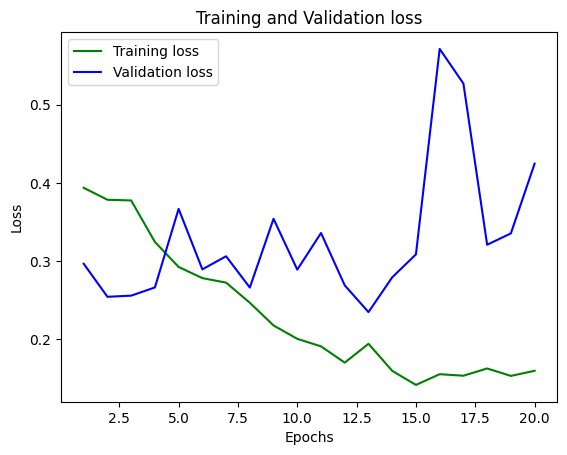

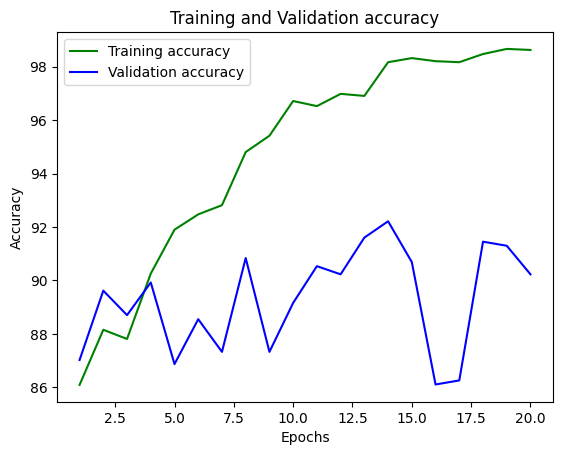

[[267  50]
 [ 14 324]]
True positive =  267
False positive =  50
False negative =  14
True negative =  324




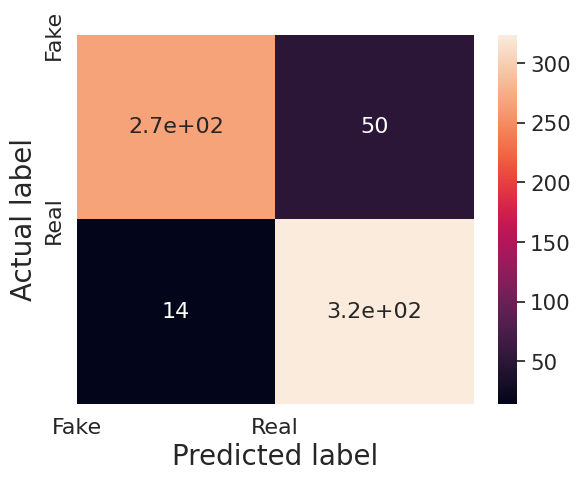

Calculated Accuracy 90.22900763358778


In [ ]:
from sklearn.metrics import confusion_matrix

lr = 1e-5 #lr (learning rate)

num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss().cuda()

train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

for epoch in range(1, num_epochs + 1):
    train_l, train_acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    train_loss_avg.append(train_l)
    train_accuracy.append(train_acc)
    true, pred, test_l, test_acc = test(epoch, model, valid_loader, criterion)
    test_loss_avg.append(test_l)
    test_accuracy.append(test_acc)

plot_loss(train_loss_avg, test_loss_avg, len(train_loss_avg))
plot_accuracy(train_accuracy, test_accuracy, len(train_accuracy))

conf_mat = confusion_matrix(true, pred)
print(conf_mat)
print_confusion_matrix(true, pred)